<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>

# Machine Translation with Seq2Seq models.

Sequence to sequence models can be also used for machine translation. We only need a dataset where inputs and outputs are the sentences in different languages. For this we can use [this website](https://www.manythings.org/anki/) with various datasets specificly for traning a machine translation model. We are going to use an RNN based encoder-decoder architecture to translate English to [Spanish | French | Dutch].

The original paper presents the idea in a very straigthforward manner. In this notebook we will have a look how can we implement a similar architecture and then extend it with the **attention** mechanism.

If you would like a more visual explanation visit this [blogpost](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/).

The code presented here is adapted from the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

## Importing Libraries

In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from os.path import join

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

We are going to use PyTorch to build models, however, Keras provides a very nice way of downloading the data. 

In [17]:
def download_file(url, path):
    """
    Download file and save it to the defined location
    
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """
    import requests
    from tqdm.notebook import tqdm
    import os
    
    
    if os.path.exists(path):
        print('File "{}" already exists. Skipping download.'.format(path))
        return
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

def unzip(path_to_zip, folder_name):
    import zipfile
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print('Extracted {} content to {}'.format(path_to_zip, folder_name))
        
URL = 'https://github.com/illyakaynov/masterclass_datasets/raw/master/RNN%20and%20Transformers/translation.zip'
PATH_TO_ZIP = 'translation.zip'

EXTRACT_TO = join('data')
DATA_FOLDER = join('data', 'translation')


download_file(URL, PATH_TO_ZIP)
unzip(PATH_TO_ZIP, EXTRACT_TO)

File "translation.zip" already exists. Skipping download.
Extracted translation.zip content to data


The dataset is downloaded. Now we need to pre-process it so it is suitable to be digested by a Neural Network. The first thing we need to do is to assign a unique id to every token in our corpus. We are going to reserve special tokens for the **start of the sequence (SOS)** and **end of the sequence (EOS)**. Then for every sentence that we have in the dataset, we are going to call `add_sentence()` method. This will split the sentence by the whitespace into words and then assign a unique id to that token (if it was not encountered before).

In [38]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = len(self.index2word)  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Before we do that lets remove all weird characters. And since our data is in Unicode we will convert it to ASCII. 

In [19]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Now we will prepare a small function that will read the data for any language that we will put in `data/translation` folder. We will agree that if you want to use some other languages you will need to maintain the following name for the text file: `eng-lang_to_translate.txt`. Also beware of the languages with different alphabet. You would need to adjust next methods then.

In [20]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(join(DATA_FOLDER, '{}-{}.txt'.format(lang1, lang2)), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:-1]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since training RNNs is a very long process, we will restrict the number of samples that we are going to use for training. We will use very simple sentences that starts with "I am", "They are", etc. We will also filter by the max length.

In [29]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [30]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'nld', True)
print(random.choice(pairs))

Reading lines...
Read 54972 sentence pairs
Trimmed to 3884 sentence pairs
Counting words...
Counted words:
nld 2087
eng 1779
['ik vertrek volgende week .', 'i am leaving next week .']


All in all instead of almost 60000 examples we will have only 4000. This will alow us to see the result a lot quicker. If you would like to train on larger dataset you could adjust the filters above.

## Modeling
We are going to use a envoder-decoder architecture. First of all we will build a Encoder, that will take our inputs in the original language and produce the contextualized embeddings for each word plus hidden state. This hidden state is then will be used as input to the Decoder, which output the translation.

### Encoder

<img src='https://pytorch.org/tutorials/_images/encoder-network.png'>
*Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html*

In [24]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Simple Decoder
A simple version of the decoder will use only the last output of the Encoder to translate the whole sequence. This last output is sometimes called a **context vector**, since it contain the information about the whole sequence. However, the context vector proves to be a very troublesome bottleneck, since it needs to compress a lot of information into a small vector.

<img src='https://pytorch.org/tutorials/_images/decoder-network.png'>
*Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html*

In [25]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder
We could extend Decoder with attention mechanism where we also take all outputs of the encoder and then "decide" what parts of the ouput is "interesting to attend to". The attention weights are going to be influenced by the decoder hidden state and the embeddings of the previous input.

<img src='https://pytorch.org/tutorials/_images/attention-decoder-network.png'>
*Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html*

In [32]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [33]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Training
The training process will be a little bit more involved than usual. We will need to save all the outputs of the encoder and feed them to the decoder. While we decoding a sequence, we can also cheat a bit. Instead of taking the output of the decoder at the one-step as an input for the following, we can instead use a real value from the ground truth. This will greatly speed up the training since the error generated at the beginning of the sequence will not propagate further. This technique is called [teacher forcing](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). However, since we are not able to do something like this when the output is unknown we still need to teach the decoder to rely on its own outputs. Therefore we will alternate between using the real output or the groundtruth with a 50% probability of choosing one or the other.

In [34]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [35]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [36]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [81]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [82]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [83]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

3m 23s (- 47m 31s) (5000 6%) 2.9061
6m 19s (- 41m 4s) (10000 13%) 2.3679
9m 7s (- 36m 28s) (15000 20%) 2.0607
12m 4s (- 33m 13s) (20000 26%) 1.8328
14m 55s (- 29m 51s) (25000 33%) 1.6487
17m 41s (- 26m 32s) (30000 40%) 1.5008
20m 17s (- 23m 11s) (35000 46%) 1.3405
22m 54s (- 20m 2s) (40000 53%) 1.2505
25m 28s (- 16m 59s) (45000 60%) 1.1281
28m 5s (- 14m 2s) (50000 66%) 1.0491
30m 55s (- 11m 14s) (55000 73%) 0.9624
33m 37s (- 8m 24s) (60000 80%) 0.8980
36m 20s (- 5m 35s) (65000 86%) 0.8319
38m 58s (- 2m 47s) (70000 93%) 0.8136
41m 33s (- 0m 0s) (75000 100%) 0.7339


In [84]:
evaluateRandomly(encoder1, attn_decoder1)

> elle est aimee de ses amies .
= she s loved by her friends .
< she s loved by her friends . <EOS>

> il n y a rien a en tirer .
= he is beyond help .
< he s got in . <EOS>

> nous ne sommes pas prisonnieres .
= we re not prisoners .
< we re not prisoners . <EOS>

> je m ennuie . faisons quelque chose !
= i m bored . let s do something .
< i m out of new new . <EOS>

> ils ne sont pas en ville .
= they re out of town .
< they re out of town . <EOS>

> nous mangeons des haricots .
= we re eating beans .
< we re eating beans . <EOS>

> je suis submerge de travail .
= i m swamped with work .
< i m swamped with my work . <EOS>

> je suis soulagee que tu sois en securite .
= i m relieved that you re safe .
< i m just safe that you . <EOS>

> je suis optimiste de nature .
= i am an optimist by nature .
< i m an optimist nature . <EOS>

> je m en rejouis d avance .
= i m looking forward to that .
< i m looking to hear it . <EOS>



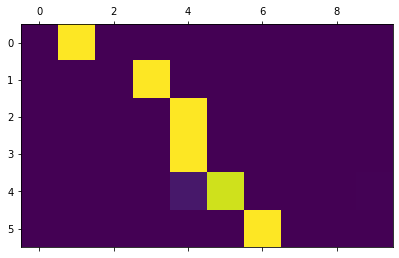

In [90]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


<ipython-input-91-9b51ff8fc28e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-91-9b51ff8fc28e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


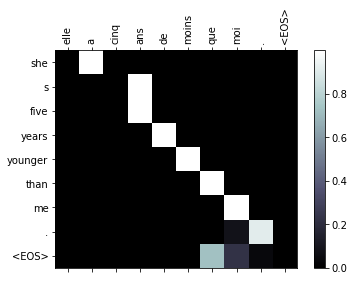

input = elle est trop petit .
output = she s too too . <EOS>


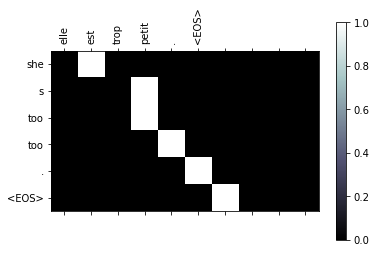

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


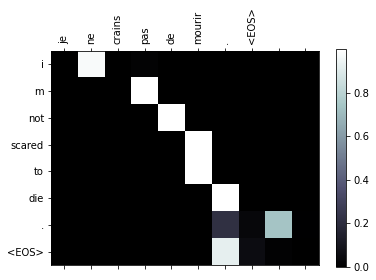

input = c est un jeune directeur plein de talent .
output = he s a intelligent man of . . <EOS>


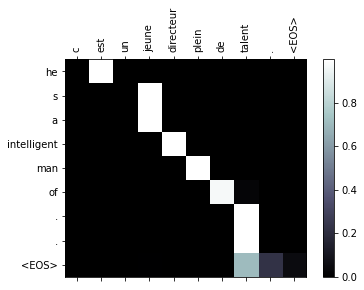

In [91]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")